In [88]:
#############
# LIBRARIES #
#############

# libraries to interact with the operating system 
import os
import sys
import glob
# libraries for data structuration and calculations
import pandas as pd  # to create data frames
import numpy as np   # most important numerical calculations
# to read in mat files
import readmat
# needed to extract the run number out of the parentesis of the string in the SPM.mat file
import re
# library for neuroimaging
import nibabel as nib
# machine learning algorithms and stuff
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, PredefinedSplit, permutation_test_score
# to check and optimize time performance
import time
import multiprocessing
# plotting
import matplotlib.pyplot as plt

In [240]:
# variables for permutation testing
rng_seed = 1

# Number of permutations
n_permutations = 1000

# Number of CPUs
max_num_CPU = 24                          # do not use more than that
num_CPU = multiprocessing.cpu_count()     # get number of cores
# TODO: improve
n_proc = min([num_CPU,max_num_CPU])       # set the number of cores that should be used

In [247]:
################################################################################################
# TEST FIELD TO DECODE ONLY ONE DECODER ON ONE SUBJECT AND ONE ROI - LATER TO BE USED IN LOOPS #
################################################################################################

# declare all path names
data_dir = '/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/spm12-glm'     # directory where to look for subjects
GLM_name = 'TrickVersionSpecialMoment'
GLM_dir = os.path.join(data_dir, GLM_name)
surfer_dir = '/Users/vpl/Documents/Master_Thesis/DATA/BIDS_playground/derivatives/surfer/'
subject_name = 'sub-%02i' %1
subject_dir = os.path.join(GLM_dir, subject_name)
SPM_mat_dir = os.path.join(subject_dir , 'SPM.mat')
ROI_name = '*.wang15atlas.LO1.nii'
ROI_dir = os.path.join(surfer_dir,subject_name,'ROIs',ROI_name)

##############################################################
# TODO: write recursive function that reads in all files in  #
# case there are more than two files (eg. both hemispheres of#
# LO1 and LO2)                                               #
##############################################################

# read in the left and right hemisphere files of the current ROI
all_ROI_parts = glob.glob(ROI_dir)
left = nib.load(all_ROI_parts[0])
right = nib.load(all_ROI_parts[1])

# get data from read file
left_mask = left.get_fdata()
right_mask = right.get_fdata()

# convert into numpy array - IMPORTANT set the dtype for bitwise comparision 
left_mask = np.asarray(left_mask,dtype=bool)
right_mask = np.asarray(right_mask,dtype=bool)

# combine both hemispheres
left_right = np.bitwise_or(right_mask, left_mask)
# make it one dimensional
left_right = left_right.flatten()

label_names = [
    'Appear',
    'Change',
    'Vanish'
] 
analysis = ''     # we can do searchlight, wholebrain or ROI analysis

# From the previously created SPM.mat file we read in information we need
# The filenames of our beta images
SPM_betadict = readmat.load(SPM_mat_dir, isStruct=True)['SPM']['Vbeta']
betas = [f['fname'] for f in SPM_betadict]
# The corresponding Regressor names - are in form of 
SPM_regressors = readmat.load(SPM_mat_dir,isStruct=True)['SPM']['xX']['name']
data_dict = {
    'Regressors': SPM_regressors,
    'BetaNames': betas
}

label_df = pd.DataFrame(data_dict, columns=data_dict.keys())
x = [' '.join(re.findall(r"\((\d+)\)",string)) for string in label_df.Regressors]
runs = [int(s_filter.split()[0]) for s_filter in x]
label_df['Runs'] = runs
regressors_of_interest = [True if any(i in n for i in label_names) else False for n in SPM_regressors]
label_df = label_df.iloc[regressors_of_interest]
label_df['Chunks'] = label_df.Runs//2
label_df['Labels'] = np.nan
for l in label_names:
    label_df.Labels[label_df.Regressors.str.contains(l)] = l

betas = []
for b, beta in enumerate(label_df.BetaNames):
    beta_nii = nib.load(os.path.join(subject_dir,beta))
    beta_data = beta_nii.get_fdata()
    beta_data = beta_data.flatten()
    beta_data = beta_data[left_right]
    beta_data = beta_data[~np.isnan(beta_data)]
    betas.append(beta_data)
betas = np.array(betas)

/Users/vpl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [248]:
any(sum(np.isnan(betas)))

False

In [249]:
targets = np.asarray(label_df.Labels)
chunks = np.asarray(label_df.Chunks)
if n_permutations > 0:
    res = permutation_test_score(
        LDA(solver='lsqr', shrinkage='auto'),
        betas,
        targets,
        groups=chunks,
        cv=PredefinedSplit(chunks),
        n_permutations=n_permutations,
        random_state=rng_seed,
        n_jobs=n_proc,
        verbose=3)
    accuracy = res[0]
    null_distribution = res[1]
    p_value = res[2]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   41.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  4.5min
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:  5.7min finished


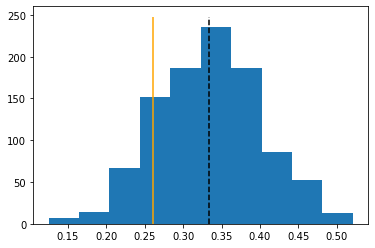

In [250]:
if n_permutations > 0:
    plt.hist(null_distribution)
    y_min, y_max = plt.ylim()
    plt.vlines(1/len(label_names), y_min, y_max, color='k', linestyles='--')
    plt.vlines(accuracy, y_min, y_max, color='orange')

In [ ]:
# outer loop - iterating over subjects
for sub,s in enumerate(subjects):
    
    # probably better use os.path.join()
    GLM_dir = ''      # directory of the GLM used (we have more than one GLM - probably going to be an array)
    betadata_dir = data_dir + GLM_dir + sub # folder containing the beta images from the previously calculated GLM 
    betas = nib.load(betadata_dir)

    SPM_mat_dir = betadata_dir + 'SPM.mat'
    SPM_mat = readmat.load(SPM_mat_dir, isStruct=True)

    mask_dir = ''     # folder containing mask images ()
    ROIs = ''
    output_dir = ''   # where to store the results
    
    # inner loop - iterating over mask (=ROIs)
    for r, roi in enumerate(ROIs):
        # load in ROI mask image
        mask_img = nib.load(roi)
        # get all beta files
        betafiles = ''
        # iterate over all beta images in directory
        for b, beta in enumerate (betafiles):
            # load in beta file
            beta_img = nib.load(beta)
            beta_data = beta_img.get_fdata()
            # apply mask on beta image
            

In [ ]:
# load NIfTIs 
mask = nib.load(mask_dir)       # check out how this works for multiple masks - probably need to loop over all masks
betas = nib.load(batadata_dir)  # check out how this works for non-compressed data - or compress the data

# Convert multiple 3D (or one 4D) data to 2D format

# define what data should be training and what data should be test data 
# we want to train on two third and test on the remaining third (we showed videos of balls, cards and sticks appearing, changing color or vanishing)
# therefore we train on the videos of two objects and test on the remaining object using cross validation

# Do the actual decoding

In [105]:
###############################################
# TEST DIFFERENT WAYS OF LOADING MATLAB FILES #
###############################################
#import tables
#import scipy
#import h5py
#from mat4py import loadmat

readmat_example = readmat.load(SPM_mat_dir, isStruct=True)['SPM']['Vbeta']
#table_example = tables.open_file(SPM_mat_dir)   # ERROR
#scipy_example = scipy.io.loadmat(SPM_mat_dir)
#hdf_example = h5py.File(SPM_mat_dir,'r')        # ERROR
#data = f.get('data/variable1')
#mat4py_example = loadmat(SPM_mat_dir)           # ERROR